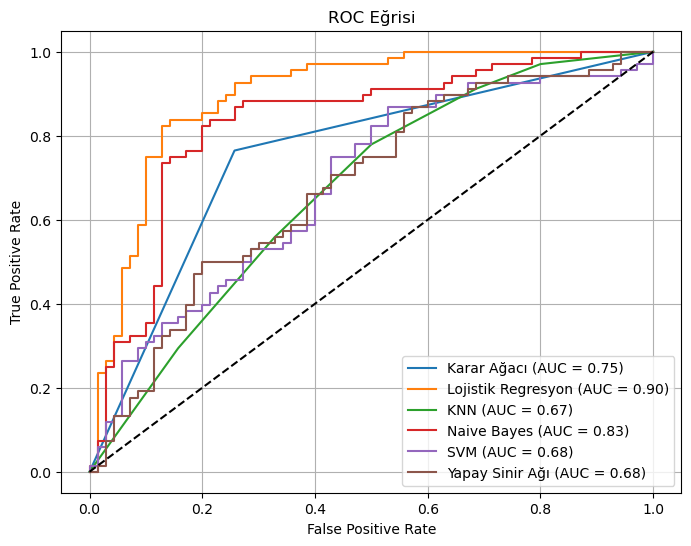

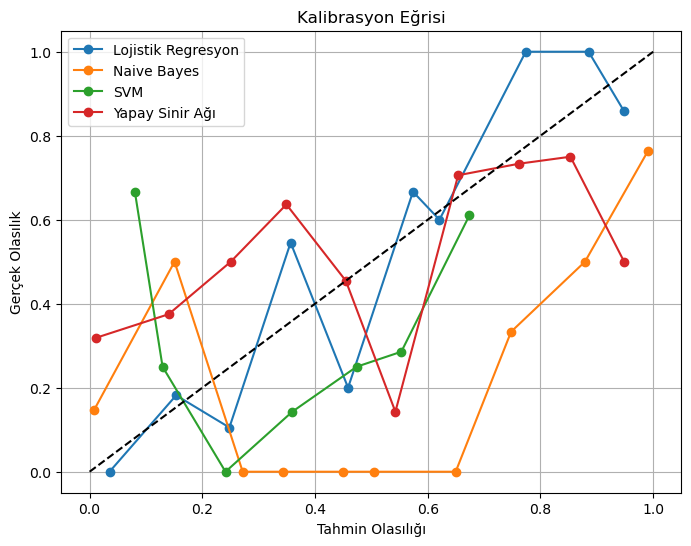

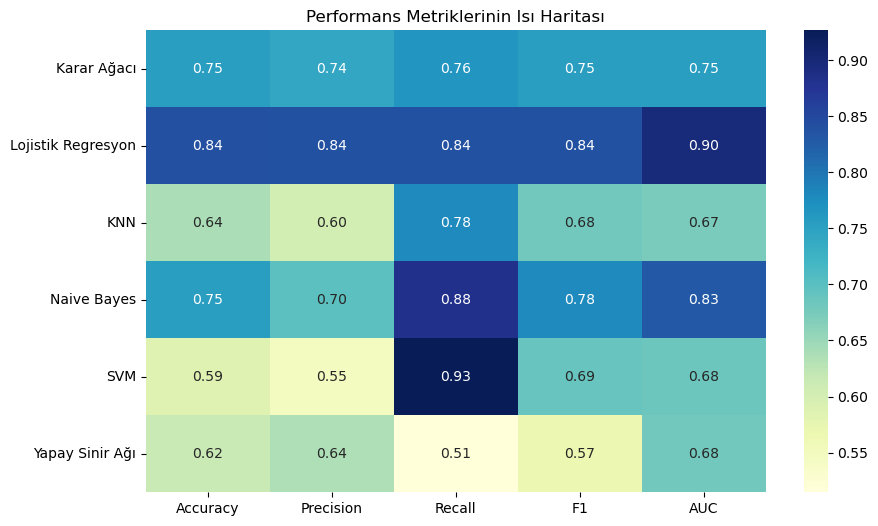

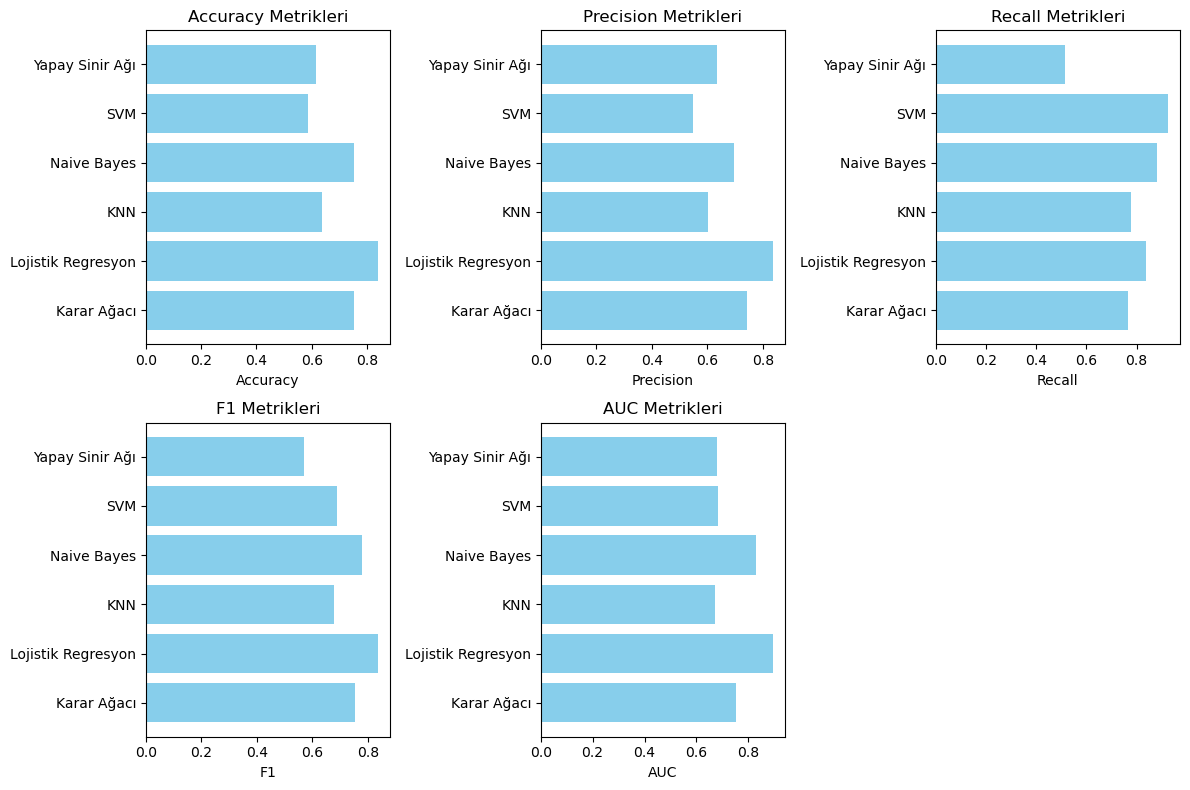

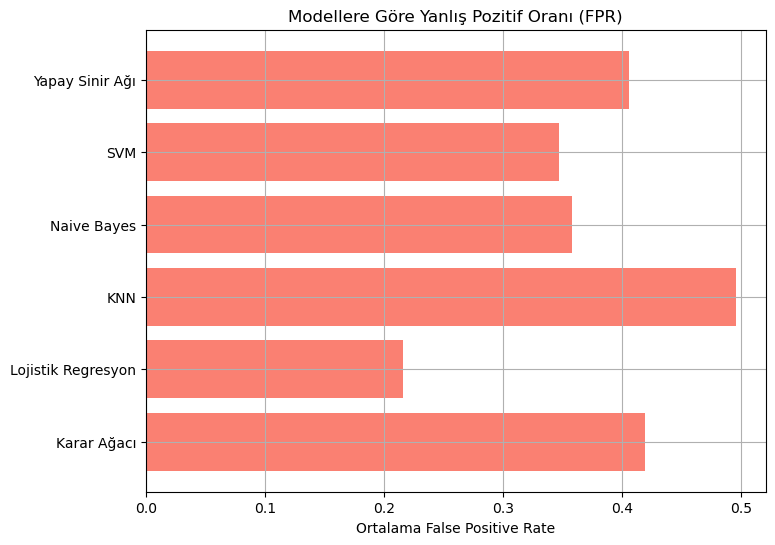

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.calibration import calibration_curve
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             roc_curve, roc_auc_score)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

# 1. Veri setinin yüklenmesi
column_names = ['A'+str(i) for i in range(1, 16)] + ['class']
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/credit-screening/crx.data'
df = pd.read_csv(url, names=column_names, na_values='?')

# 2. Eksik verilerin işlenmesi
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].fillna(df[col].mode()[0])
    else:
        df[col] = df[col].fillna(df[col].mean())

# 3. Kategorik verilerin sayısallaştırılması
categorical_cols = df.select_dtypes(include='object').columns
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# 4. Modelleme
X = df.drop('class', axis=1)
y = df['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modeller
models = {
    "Karar Ağacı": DecisionTreeClassifier(),
    "Lojistik Regresyon": LogisticRegression(max_iter=1000, solver='liblinear'),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Naive Bayes": GaussianNB(),
    "SVM": SVC(probability=True, kernel='rbf'),
    "Yapay Sinir Ağı": MLPClassifier(hidden_layer_sizes=(50,), max_iter=1000, random_state=42)
}

results = {}

# Eğitim ve test
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "AUC": roc_auc_score(y_test, y_prob),
        "y_prob": y_prob,
        "y_pred": y_pred,
        "model": model
    }

# ROC Eğrileri
plt.figure(figsize=(8, 6))
for name, res in results.items():
    fpr, tpr, _ = roc_curve(y_test, res["y_prob"])
    plt.plot(fpr, tpr, label=f"{name} (AUC = {res['AUC']:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Eğrisi")
plt.legend()
plt.grid(True)
plt.show()

# Kalibrasyon Eğrileri
plt.figure(figsize=(8, 6))
for name in ["Lojistik Regresyon", "Naive Bayes", "SVM", "Yapay Sinir Ağı"]:
    prob_true, prob_pred = calibration_curve(y_test, results[name]["y_prob"], n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o', label=name)
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("Tahmin Olasılığı")
plt.ylabel("Gerçek Olasılık")
plt.title("Kalibrasyon Eğrisi")
plt.legend()
plt.grid(True)
plt.show()

# Performans metriklerinin ısı haritası
metrics_df = pd.DataFrame({name: {k: v for k, v in res.items() if k in ["Accuracy", "Precision", "Recall", "F1", "AUC"]} for name, res in results.items()}).T
plt.figure(figsize=(10, 6))
sns.heatmap(metrics_df, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Performans Metriklerinin Isı Haritası")
plt.show()

# Performans metriklerinin bar grafikleri
metrics_names = ["Accuracy", "Precision", "Recall", "F1", "AUC"]
plt.figure(figsize=(12, 8))
for i, metric in enumerate(metrics_names):
    plt.subplot(2, 3, i+1)
    metric_values = [res[metric] for res in results.values()]
    plt.barh(list(results.keys()), metric_values, color='skyblue')
    plt.xlabel(metric)
    plt.title(f"{metric} Metrikleri")
    plt.tight_layout()

# Ortalama False Positive Rate hesaplama ve görselleştirme
fpr_values = {}
for name, res in results.items():
    fpr, tpr, _ = roc_curve(y_test, res["y_prob"])
    fpr_values[name] = np.mean(fpr)  # Ortalama FPR alınır

# Bar grafiği
plt.figure(figsize=(8, 6))
plt.barh(list(fpr_values.keys()), list(fpr_values.values()), color='salmon')
plt.xlabel("Ortalama False Positive Rate")
plt.title("Modellere Göre Yanlış Pozitif Oranı (FPR)")
plt.grid(True)
plt.show()


plt.show() 